In [1]:
import pandas as pd
import numpy as np
import keras
from sklearn.preprocessing import Imputer
from keras.utils import to_categorical
import sys

    
def prepare_input_df(data, is_training=True):    
    data.index = range(0, len(data))
    data = data.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

    # Make dummy variables for annotation
    one_hot_data = pd.concat([data, pd.get_dummies(data['Pclass'], prefix='Pclass'), pd.get_dummies(data['Sex'], prefix='Sex'), pd.get_dummies(data['Embarked'], prefix='Embarked') ], axis=1)

    # Drop the previous rank column
    one_hot_data = one_hot_data.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

    one_hot_data[:10]
    data = one_hot_data

    # imputing missing values
    data.loc[~data['Cabin'].isnull(), ['Cabin']] = 1
    data.loc[data['Cabin'].isnull(), ['Cabin']] = 0
    
    data.loc[data['Age'].isnull(), ['Age']] = data['Age'].max()
    

    ## replace YES with 1 and NO with 0 and store to 'y'
    # label_mapping = {'YES': 1, 'NO': 0}
    # data = data.replace({'Survived': label_mapping})

    if is_training:
        y = data['Survived']
        
    # imputing missing values
    fill_NaN = Imputer(missing_values=np.nan, strategy='median', axis=1)
    imputed_DF = pd.DataFrame(fill_NaN.fit_transform(data))
    imputed_DF.columns = data.columns
    data.index = data.index
    data = imputed_DF
    # data = data.interpolate(method='spline', order=2) # interpolate missing values
    #data = data.fillna(0)

    # normalise data
    data = (data - data.min()) / (data.max() - data.min())

    
    if is_training:
        data['Survived'] = y
    
    return data

data = pd.read_csv('train.csv', sep=',')
data = prepare_input_df(data)

data[:10]

# test = pd.read_csv('test.csv', sep=',')
# test_data = prepare_input_df(test, False)
# test_data[:10]



Using TensorFlow backend.


,Survived,Age,SibSp,Parch,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,0.271174,0.125,0.000000,0.014151,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,0.472229,0.125,0.000000,0.139136,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,0.321438,0.000,0.000000,0.015469,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1,0.434531,0.125,0.000000,0.103644,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,0.434531,0.000,0.000000,0.015713,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
5,0,1.000000,0.000,0.000000,0.016510,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6,0,0.673285,0.000,0.000000,0.101229,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7,0,0.019854,0.375,0.166667,0.041136,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
8,1,0.334004,0.000,0.333333,0.021731,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
9,1,0.170646,0.125,0.000000,0.058694,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [2]:
np.random.seed(3)

# # Split X into training and test sets
# sample = np.random.choice(data.index, size=int(len(data)*0.7), replace=False)
# train_data, test_data = data.iloc[sample], data.drop(sample)

# train using all rows from train.csv
train_data = data

print("Number of training samples is", len(train_data))
# print("Number of testing samples is", len(test_data))

Number of training samples is 891


In [3]:
X_train = np.array(train_data.drop('Survived', axis=1))
y_train = np.array(keras.utils.to_categorical(train_data['Survived'], 2))

# X_test = np.array(test_data.drop('Survived', axis=1))
# y_test = np.array(keras.utils.to_categorical(test_data['Survived'], 2))


print("Number of rows in X_train: ", len(X_train))
print("Number of rows in y_train: ", len(y_train))
# print("Number of rows in X_test", len(X_test))
# print("Number of rows in y_test", len(y_test))

Number of rows in X_train:  891
Number of rows in y_train:  891


In [4]:
data.columns
# tt = pd.DataFrame(y_train)
# tt.columns = ['c0', 'c1']
# tt.loc[tt['c1'] == 1.0]
# data
X_train.shape

(891, 13)

### Build Neural Network with `sckit-learn` wrapper for `Keras`

In [5]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras import regularizers
from keras.metrics import categorical_accuracy
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(init_mode='he_normal'):
    
    reglr = 0.0001
    # Building the model
    model = Sequential()

    model.add(Dense(32, kernel_initializer=init_mode, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(reglr) ))
    model.add(Dropout(.4))

#     model.add(Dense(32, kernel_initializer=init_mode, activation='relu', kernel_regularizer=regularizers.l2(reglr)))
#     model.add(Dropout(.4))
    
    model.add(Dense(16, kernel_initializer=init_mode, activation='relu', kernel_regularizer=regularizers.l2(reglr)))
    model.add(Dropout(.4))
    
    model.add(Dense(2, activation='softmax'))

    # Compiling the model
    sgd_optim = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    # adam=keras.optimizers.Adam(lr=0.00001)
          
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)
# model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
model

### Grid Search for optimal Training Optimisation Algorithm - [ DONE ]

In [6]:
# Define the grid search parameters

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

param_grid = dict(optimizer=optimizer)

# Run grid search
if 0:
    grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, n_jobs=1)

    grid_tuning = grid.fit(X_train, y_train)

#### Results from optimizer tuning

In [7]:
if 0:
    print("Best: %f using %s" % (grid_tuning.best_score_, grid_tuning.best_params_))
    means = grid_tuning.cv_results_['mean_test_score']
    stds = grid_tuning.cv_results_['std_test_score']
    params = grid_tuning.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

<br/><br/>

### Grid Search for optimal learning rate, momentum and number of epochs

In [8]:
# Define the grid search parameters

# learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
# param_grid = dict(lr=learn_rate, momentum=momentum)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)

if 0:
    batch_size = [10, 20, 40, 60, 80, 100]
    epochs = [10, 50, 100]
    init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    param_grid = dict(init_mode=init_mode, batch_size=batch_size, epochs=epochs)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
    grid_tuning = grid.fit(X_train, y_train)

#### Results from optimizer tuning

In [9]:
if 0:
    print("Best: %f using %s" % (grid_tuning.best_score_, grid_tuning.best_params_))
    means = grid_tuning.cv_results_['mean_test_score']
    stds = grid_tuning.cv_results_['std_test_score']
    params = grid_tuning.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

<br/><br/><br/><br/><br/><br/><br/>

## Train model using optimal parameters

In [10]:
# # # Split X into training and test sets
sample = np.random.choice(data.index, size=int(len(data)*0.7), replace=False)
train_data, test_data = data.iloc[sample], data.drop(sample)

X_train = np.array(train_data.drop('Survived', axis=1))
y_train = np.array(keras.utils.to_categorical(train_data['Survived'], 2))

X_test = np.array(test_data.drop('Survived', axis=1))
y_test = np.array(keras.utils.to_categorical(test_data['Survived'], 2))

In [11]:
from keras.callbacks import ModelCheckpoint   

# Creating the model
model = create_model()

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

# Fit the model
# early_stopping = [EarlyStopping(monitor='acc', patience=2)] # do not apply without checking
out = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, 
                validation_split=0.1, callbacks=[checkpointer])

Train on 560 samples, validate on 63 samples
Epoch 1/100
560/560 [==============================] - 0s 742us/step - loss: 0.8186 - acc: 0.5054 - val_loss: 0.6786 - val_acc: 0.5873
Epoch 2/100
560/560 [==============================] - 0s 83us/step - loss: 0.7064 - acc: 0.5750 - val_loss: 0.6346 - val_acc: 0.6825
Epoch 3/100
560/560 [==============================] - 0s 86us/step - loss: 0.7094 - acc: 0.5554 - val_loss: 0.6103 - val_acc: 0.7302
Epoch 4/100
560/560 [==============================] - 0s 80us/step - loss: 0.7004 - acc: 0.5804 - val_loss: 0.5907 - val_acc: 0.7460
Epoch 5/100
560/560 [==============================] - 0s 86us/step - loss: 0.6488 - acc: 0.6321 - val_loss: 0.5711 - val_acc: 0.7619
Epoch 6/100
560/560 [==============================] - 0s 83us/step - loss: 0.6330 - acc: 0.6554 - val_loss: 0.5557 - val_acc: 0.7937
Epoch 7/100
560/560 [==============================] - 0s 84us/step - loss: 0.5935 - acc: 0.7054 - val_loss: 0.5337 - val_acc: 0.8095
Epoch 8/100
560/

560/560 [==============================] - 0s 53us/step - loss: 0.4774 - acc: 0.7964 - val_loss: 0.4244 - val_acc: 0.8095
Epoch 29/100
560/560 [==============================] - 0s 87us/step - loss: 0.4747 - acc: 0.7911 - val_loss: 0.4215 - val_acc: 0.8095
Epoch 30/100
560/560 [==============================] - 0s 82us/step - loss: 0.4790 - acc: 0.7982 - val_loss: 0.4165 - val_acc: 0.8254
Epoch 31/100
560/560 [==============================] - 0s 47us/step - loss: 0.4948 - acc: 0.7857 - val_loss: 0.4184 - val_acc: 0.8095
Epoch 32/100
560/560 [==============================] - 0s 49us/step - loss: 0.4939 - acc: 0.7679 - val_loss: 0.4222 - val_acc: 0.8254
Epoch 33/100
560/560 [==============================] - 0s 48us/step - loss: 0.4811 - acc: 0.7875 - val_loss: 0.4201 - val_acc: 0.8095
Epoch 34/100
560/560 [==============================] - 0s 48us/step - loss: 0.4899 - acc: 0.7714 - val_loss: 0.4181 - val_acc: 0.8254
Epoch 35/100
560/560 [==============================] - 0s 54us/step

Epoch 59/100
560/560 [==============================] - 0s 51us/step - loss: 0.4645 - acc: 0.7964 - val_loss: 0.4154 - val_acc: 0.8413
Epoch 60/100
560/560 [==============================] - 0s 79us/step - loss: 0.4492 - acc: 0.8089 - val_loss: 0.4124 - val_acc: 0.8413
Epoch 61/100
560/560 [==============================] - 0s 81us/step - loss: 0.4457 - acc: 0.8036 - val_loss: 0.4122 - val_acc: 0.8413
Epoch 62/100
560/560 [==============================] - 0s 48us/step - loss: 0.4547 - acc: 0.8000 - val_loss: 0.4158 - val_acc: 0.8413
Epoch 63/100
560/560 [==============================] - 0s 51us/step - loss: 0.4496 - acc: 0.8000 - val_loss: 0.4156 - val_acc: 0.8413
Epoch 64/100
560/560 [==============================] - 0s 55us/step - loss: 0.4723 - acc: 0.8250 - val_loss: 0.4164 - val_acc: 0.8413
Epoch 65/100
560/560 [==============================] - 0s 51us/step - loss: 0.4459 - acc: 0.8036 - val_loss: 0.4155 - val_acc: 0.8413
Epoch 66/100
560/560 [==============================] -

560/560 [==============================] - 0s 49us/step - loss: 0.4447 - acc: 0.8179 - val_loss: 0.4166 - val_acc: 0.8254
Epoch 92/100
560/560 [==============================] - 0s 48us/step - loss: 0.4271 - acc: 0.8143 - val_loss: 0.4154 - val_acc: 0.8254
Epoch 93/100
560/560 [==============================] - 0s 47us/step - loss: 0.4463 - acc: 0.8161 - val_loss: 0.4135 - val_acc: 0.8413
Epoch 94/100
560/560 [==============================] - 0s 50us/step - loss: 0.4421 - acc: 0.8250 - val_loss: 0.4123 - val_acc: 0.8571
Epoch 95/100
560/560 [==============================] - 0s 48us/step - loss: 0.4404 - acc: 0.8179 - val_loss: 0.4131 - val_acc: 0.8413
Epoch 96/100
560/560 [==============================] - 0s 49us/step - loss: 0.4448 - acc: 0.8232 - val_loss: 0.4131 - val_acc: 0.8413
Epoch 97/100
560/560 [==============================] - 0s 46us/step - loss: 0.4311 - acc: 0.8214 - val_loss: 0.4136 - val_acc: 0.8571
Epoch 98/100
560/560 [==============================] - 0s 50us/step

In [12]:
out.__dict__['history'].keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

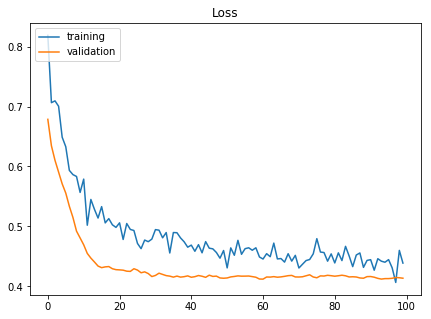

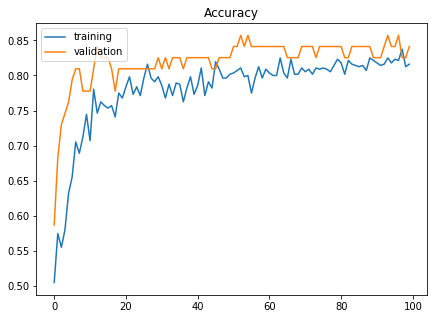

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = np.array(out.__dict__['epoch'])
acc = np.array(out.__dict__['history']['acc'])
loss = np.array(out.__dict__['history']['loss'])
val_acc = np.array(out.__dict__['history']['val_acc'])
val_loss = np.array(out.__dict__['history']['val_loss'])

f = plt.figure(figsize=(7,5))
plt.plot(epochs, loss, label='training')
plt.plot(epochs, val_loss, label='validation')
plt.legend(loc='upper left')
plt.title('Loss')

plt.show()

f = plt.figure(figsize=(7,5))
plt.plot(epochs, acc, label='training')
plt.plot(epochs, val_acc, label='validation')
plt.legend(loc='upper left')
plt.title('Accuracy')

plt.show()

f.savefig("train_validation_loss.pdf", bbox_inches='tight')

### Load the weights that yielded the best validation accuracy

In [14]:
model.load_weights('model.weights.best.hdf5')

#### Evaluating the model on the training and testing set

In [15]:
train_score = model.evaluate(X_train, y_train, verbose=1)
print("\n Training Accuracy:", train_score[1])
test_score = model.evaluate(X_test, y_test, verbose=1)
print("\n Testing Accuracy:", test_score[1])

623/623 [==============================] - 0s 20us/step

 Training Accuracy: 0.820224719197
268/268 [==============================] - 0s 23us/step

 Testing Accuracy: 0.813432835821


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
# y_pred = y.values.argmax

y_pred = model.predict_classes(X_test)

p = model.predict_proba(X_test)

print(classification_report(np.argmax(y_test, axis=1), y_pred))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))
print()
TN, FP, FN, TP = confusion_matrix(np.argmax(y_test, axis=1), y_pred).ravel()
print("TP:", TP)
print("FN:", FN)
print("TN:", TN)
print("FP:", FP)
len(p)

             precision    recall  f1-score   support

          0       0.79      0.96      0.87       167
          1       0.90      0.56      0.70       101

avg / total       0.83      0.81      0.80       268

[[161   6]
 [ 44  57]]

TP: 57
FN: 44
TN: 161
FP: 6


268

In [17]:
conc = pd.concat([pd.DataFrame(y_test), pd.DataFrame(p)], axis=1)
conc.columns = ['test_0', 'test_1', 'pred_0', 'pred_1']
subdf = conc.loc[conc['test_1'] == 1]
subdf.loc[subdf['pred_1'] >= 0.5][:5]

,test_0,test_1,pred_0,pred_1
1,0.0,1.0,0.030682,0.969318
4,0.0,1.0,0.075553,0.924447
11,0.0,1.0,0.326539,0.673461
18,0.0,1.0,0.032433,0.967567
32,0.0,1.0,0.103083,0.896917


### Predict on unseen data

In [18]:
test = pd.read_csv('test.csv', sep=',')
subm_test_data = prepare_input_df(test, False)

In [19]:
subm_test_data[:5]

y_pred = model.predict_classes(subm_test_data)
p = model.predict_proba(subm_test_data)
p[:10]

array([[ 0.87977242,  0.12022758],
       [ 0.62827998,  0.37172008],
       [ 0.82365578,  0.17634425],
       [ 0.86133784,  0.13866217],
       [ 0.54882675,  0.45117325],
       [ 0.84643185,  0.15356813],
       [ 0.479785  ,  0.52021503],
       [ 0.78024048,  0.21975955],
       [ 0.42587322,  0.57412678],
       [ 0.87301809,  0.1269819 ]], dtype=float32)

In [20]:
df = pd.DataFrame(p)
df.columns = ['pred0', 'pred1']
df[:20]

,pred0,pred1
0,0.879772,0.120228
1,0.628280,0.371720
2,0.823656,0.176344
3,0.861338,0.138662
4,0.548827,0.451173
5,0.846432,0.153568
6,0.479785,0.520215
7,0.780240,0.219760
8,0.425873,0.574127
9,0.873018,0.126982


In [21]:
comp = df.pred0 < df.pred1
comp[:20]
type(comp)

pandas.core.series.Series

In [22]:
with open("titanic_submission.csv", "w") as f: 
    f.write("PassengerId,Survived\n")
    
    for i in range(len(comp)):
        f.write(str(i + 892) + ',' + str(int(comp[i])) + "\n")